In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read in the data
data = pd.read_csv('../data/US_Accidents_March23_sampled_500k.csv')

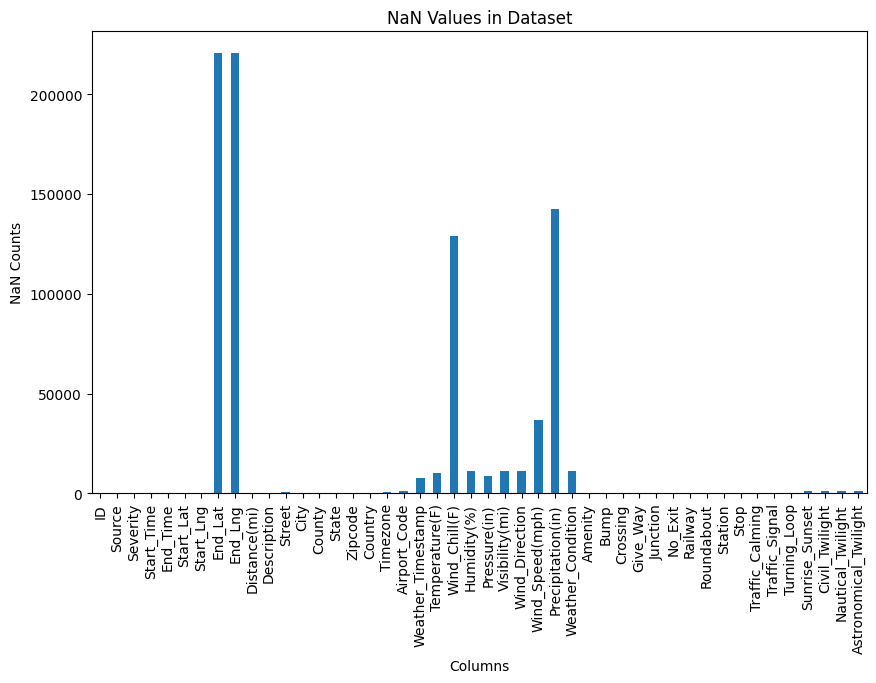

In [4]:
# nan histogram
nan_counts = data.isnull().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

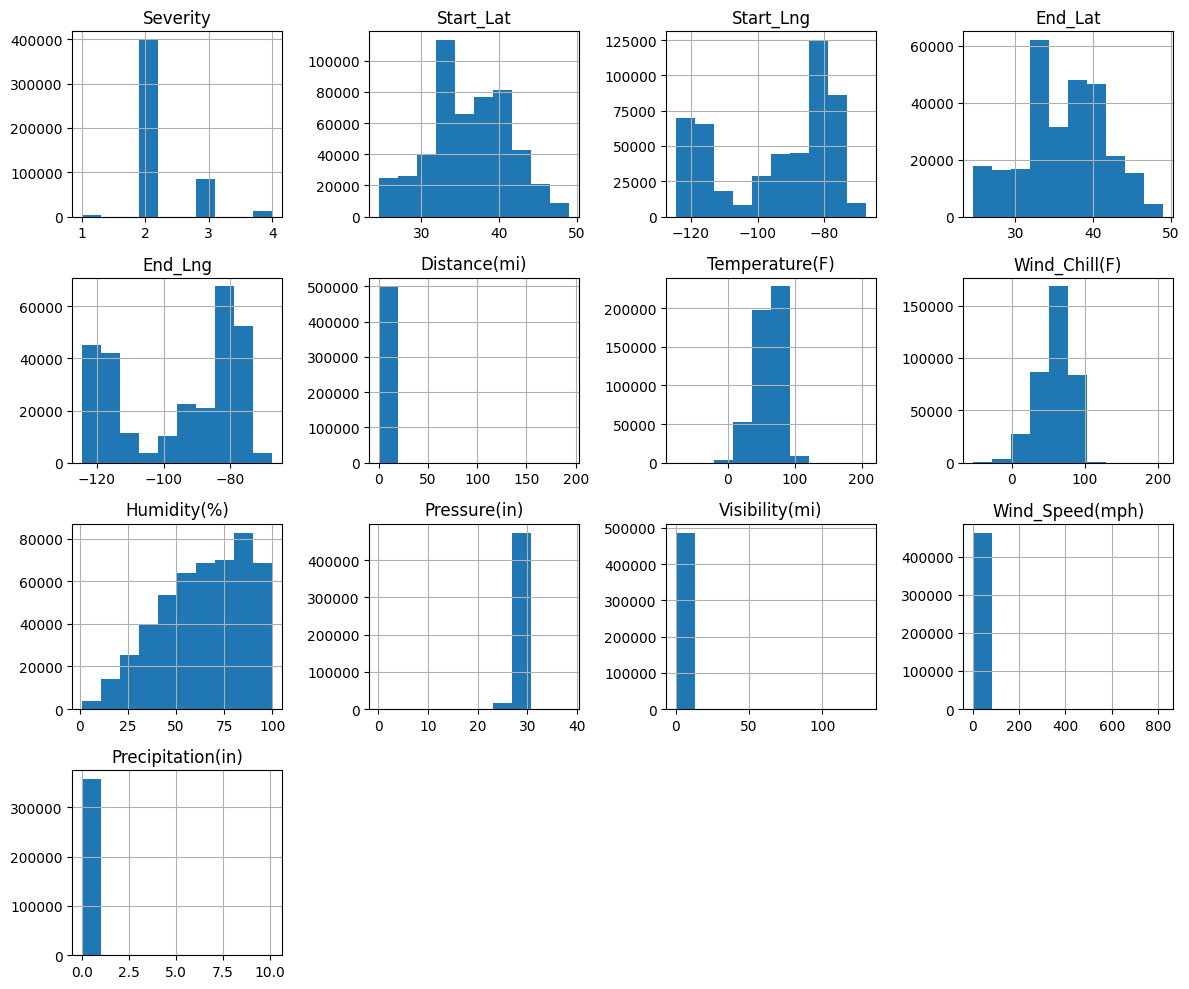

In [5]:
data.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [10]:
# data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu